In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from matplotlib.ticker import PercentFormatter

In [6]:
# Helper function for pass@k with n_augmented samples
def calculate_pass_at_k_at_n_augmented(predictions_list, n_augmented, repetitions=100):
    """Calculate expected pass@1 when sampling n_augmented predictions multiple times."""
    results = []
    for _ in range(repetitions):
        # For each repetition, sample n_augmented predictions
        sampled_correct = [random.sample(preds, min(n_augmented, len(preds)))
                           for preds in predictions_list]
        # Calculate if any prediction in each sample is correct
        pass_at_1 = np.mean([1 if any(sample) else 0 for sample in sampled_correct])
        results.append(pass_at_1)
    return np.mean(results)

In [7]:
# Helper function for pass@k with n_augmented samples
def calculate_pass_at_k_at_n_augmented(predictions_list, n_augmented, repetitions=100):
    """Calculate expected pass@1 when sampling n_augmented predictions multiple times."""
    results = []
    for _ in range(repetitions):
        # For each repetition, sample n_augmented predictions
        sampled_correct = [random.sample(preds, min(n_augmented, len(preds)))
                           for preds in predictions_list]
        # Calculate if any prediction in each sample is correct
        pass_at_1 = np.mean([1 if any(sample) else 0 for sample in sampled_correct])
        results.append(pass_at_1)
    return np.mean(results)

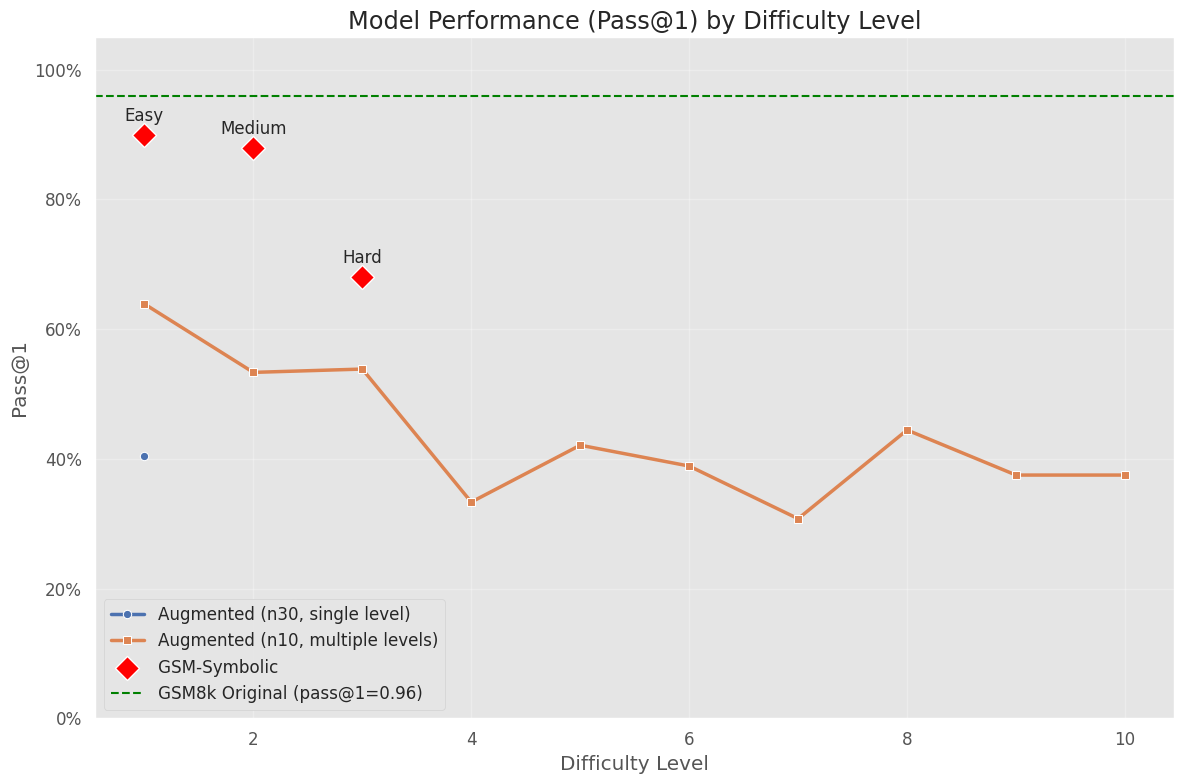

In [8]:
# Set plotting style
plt.style.use('ggplot')
sns.set_palette("deep")
plt.rcParams.update({'font.size': 12})

# 1. Plot "level vs. pass@1" across different datasets
plt.figure(figsize=(12, 8))

# For both augmented datasets
n30_df = dataframes['augmented_best_eval_result_len_42']
n10_levels_df = dataframes['augmented_best_eval_result_len_188']

# For the n30 dataset (single level)
if 'level' in n30_df.columns:
    n30_level_performance = n30_df.groupby('level')['pass_at_k'].mean().reset_index()
    sns.lineplot(data=n30_level_performance, x='level', y='pass_at_k', marker='o',
                 label='Augmented (n30, single level)', linewidth=2.5)

# For the n10 dataset (multiple levels)
if 'level' in n10_levels_df.columns:
    n10_level_performance = n10_levels_df.groupby('level')['pass_at_k'].mean().reset_index()
    sns.lineplot(data=n10_level_performance, x='level', y='pass_at_k', marker='s',
                 label='Augmented (n10, multiple levels)', linewidth=2.5)

# Add GSM-Symbolic datasets (treating them as different levels of difficulty)
gsm_symbolic_data = []
for idx, (name, level) in enumerate([('selected_easy_eval_result_len_50', 'Easy'),
                                     ('selected_medium_eval_result_len_50', 'Medium'),
                                     ('selected_hard_eval_result_len_50', 'Hard')]):
    df = dataframes[name]
    avg_performance = df['pass_at_k'].mean()
    gsm_symbolic_data.append({'level': idx+1, 'pass_at_k': avg_performance, 'difficulty': level})

gsm_symbolic_df = pd.DataFrame(gsm_symbolic_data)
sns.scatterplot(data=gsm_symbolic_df, x='level', y='pass_at_k', s=150,
                marker='D', label='GSM-Symbolic', color='red')

# Add original GSM8k performance as a reference line
orig_performance = dataframes['selected_gsm8k_eval_result_len_50']['pass_at_k'].mean()
plt.axhline(y=orig_performance, linestyle='--', color='green',
            label=f'GSM8k Original (pass@1={orig_performance:.2f})')

# Annotate GSM-Symbolic points
for _, row in gsm_symbolic_df.iterrows():
    plt.annotate(row['difficulty'],
                 (row['level'], row['pass_at_k']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Model Performance (Pass@1) by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Pass@1')
plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('level_vs_pass_at_1.png', dpi=300)
plt.show()

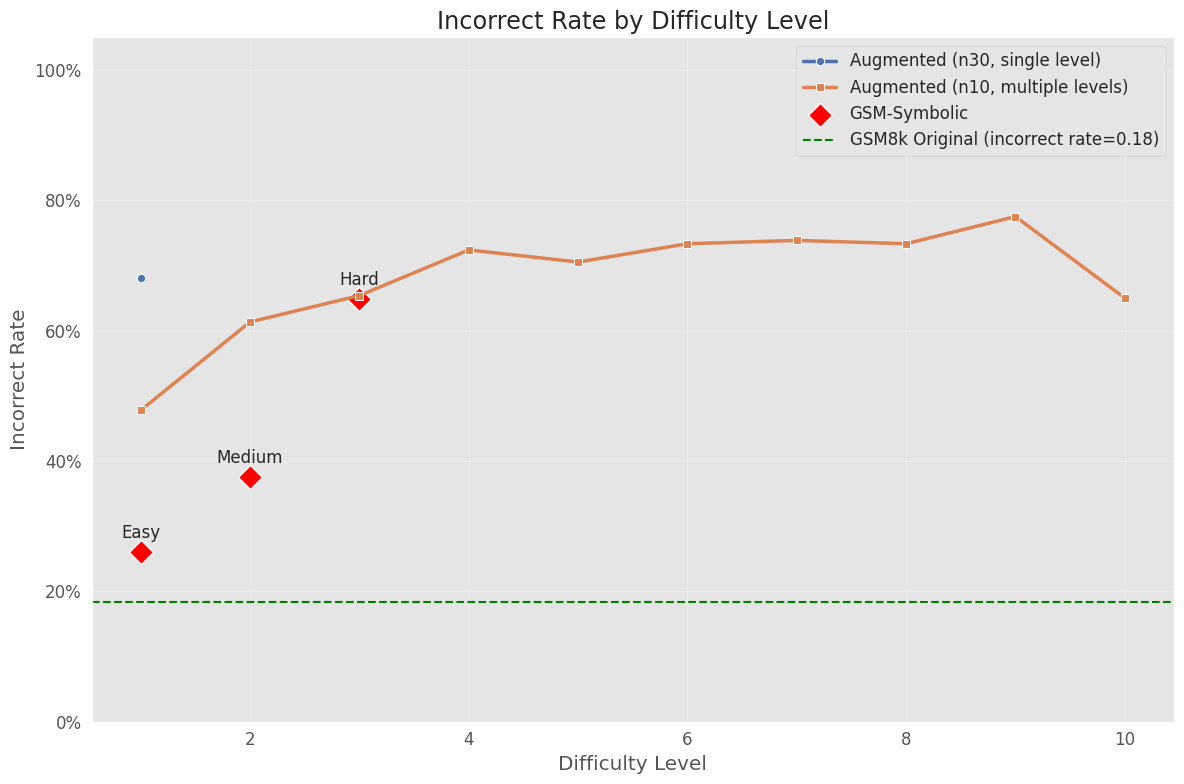

In [39]:
# 2. Plot "level vs. incorrect rate"
plt.figure(figsize=(12, 8))

# For both augmented datasets
# For n30 dataset
if 'level' in n30_df.columns:
    n30_incorrect = n30_df.groupby('level')[['correct_predictions']].apply(
        lambda x: 1 - np.mean([sum(preds)/len(preds) if len(preds) > 0 else 0
                              for preds in x['correct_predictions']])
    ).reset_index(name='incorrect_rate')

    sns.lineplot(data=n30_incorrect, x='level', y='incorrect_rate', marker='o',
                 label='Augmented (n30, single level)', linewidth=2.5)

# For n10 levels dataset
if 'level' in n10_levels_df.columns:
    n10_incorrect = n10_levels_df.groupby('level')[['correct_predictions']].apply(
        lambda x: 1 - np.mean([sum(preds)/len(preds) if len(preds) > 0 else 0
                              for preds in x['correct_predictions']])
    ).reset_index(name='incorrect_rate')

    sns.lineplot(data=n10_incorrect, x='level', y='incorrect_rate', marker='s',
                 label='Augmented (n10, multiple levels)', linewidth=2.5)

# Add GSM-Symbolic datasets
gsm_symbolic_incorrect = []
for idx, (name, level) in enumerate([('selected_easy_eval_result_len_50', 'Easy'),
                                     ('selected_medium_eval_result_len_50', 'Medium'),
                                     ('selected_hard_eval_result_len_50', 'Hard')]):
    df = dataframes[name]
    incorrect_rate = 1 - np.mean([sum(preds)/len(preds) if len(preds) > 0 else 0
                                  for preds in df['correct_predictions']])
    gsm_symbolic_incorrect.append({'level': idx+1, 'incorrect_rate': incorrect_rate, 'difficulty': level})

gsm_symbolic_incorrect_df = pd.DataFrame(gsm_symbolic_incorrect)
sns.scatterplot(data=gsm_symbolic_incorrect_df, x='level', y='incorrect_rate', s=150,
                marker='D', label='GSM-Symbolic', color='red')

# Add original GSM8k incorrect rate as a reference line
orig_df = dataframes['selected_gsm8k_eval_result_len_50']
orig_incorrect = 1 - np.mean([sum(preds)/len(preds) if len(preds) > 0 else 0
                             for preds in orig_df['correct_predictions']])
plt.axhline(y=orig_incorrect, linestyle='--', color='green',
            label=f'GSM8k Original (incorrect rate={orig_incorrect:.2f})')

for _, row in gsm_symbolic_incorrect_df.iterrows():
    plt.annotate(row['difficulty'],
                 (row['level'], row['incorrect_rate']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Incorrect Rate by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Incorrect Rate')
plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('level_vs_incorrect_rate.png', dpi=300)
plt.show()

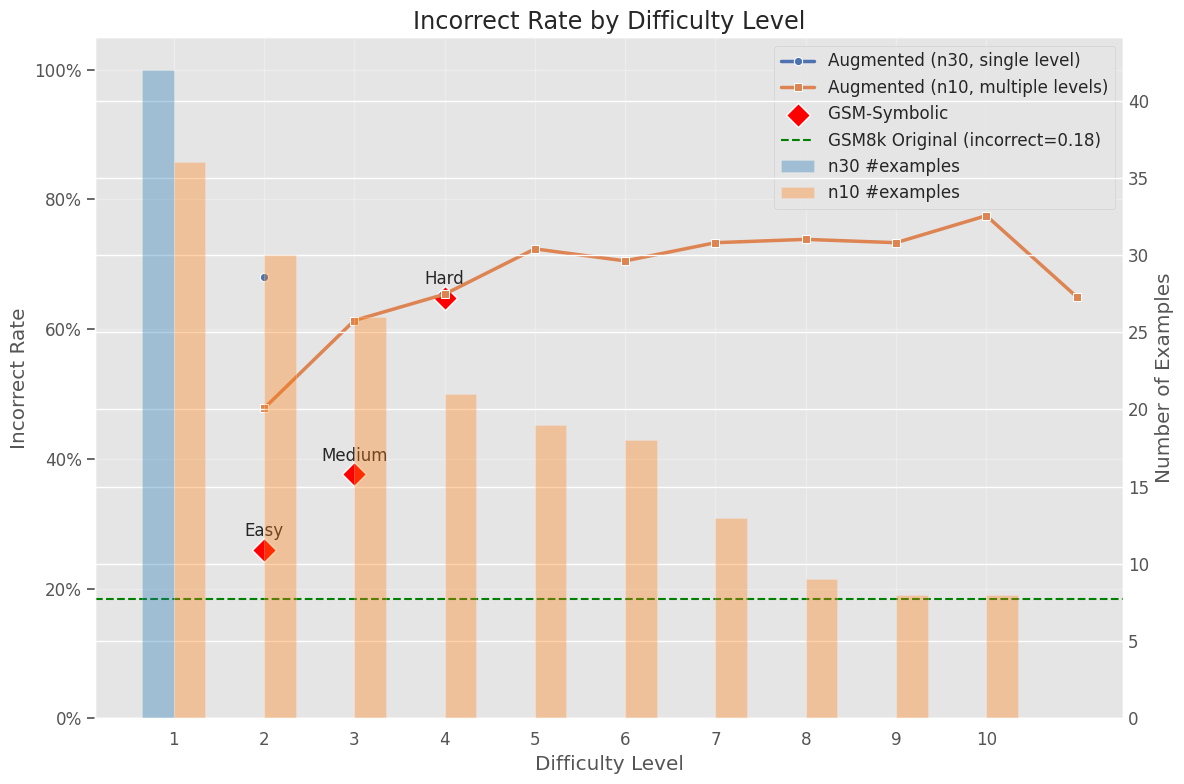

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

plt.figure(figsize=(12, 8))
ax1 = plt.gca()                      # ← primary axis (incorrect-rate)

# ───────────────────────────────
# 1.  INCORRECT-RATE LINES (unchanged)
# ───────────────────────────────
# n30
if 'level' in n30_df.columns:
    n30_incorrect = (
        n30_df.groupby('level')['correct_predictions']
        .apply(lambda preds: 1 - np.mean([sum(p)/len(p) if len(p) else 0 for p in preds]))
        .reset_index(name='incorrect_rate')
    )
    sns.lineplot(
        data=n30_incorrect, x='level', y='incorrect_rate', marker='o',
        label='Augmented (n30, single level)', linewidth=2.5, ax=ax1
    )

# n10 (multiple levels)
if 'level' in n10_levels_df.columns:
    n10_incorrect = (
        n10_levels_df.groupby('level')['correct_predictions']
        .apply(lambda preds: 1 - np.mean([sum(p)/len(p) if len(p) else 0 for p in preds]))
        .reset_index(name='incorrect_rate')
    )
    sns.lineplot(
        data=n10_incorrect, x='level', y='incorrect_rate', marker='s',
        label='Augmented (n10, multiple levels)', linewidth=2.5, ax=ax1
    )

# GSM-Symbolic points
gsm_symbolic_incorrect = []
for idx, (name, level) in enumerate([
        ('selected_easy_eval_result_len_50',   'Easy'),
        ('selected_medium_eval_result_len_50', 'Medium'),
        ('selected_hard_eval_result_len_50',   'Hard')]):
    df = dataframes[name]
    acc  = np.mean([sum(p)/len(p) if len(p) else 0 for p in df['correct_predictions']])
    gsm_symbolic_incorrect.append(
        {'level': idx+1, 'incorrect_rate': 1-acc, 'difficulty': level}
    )
gsm_symbolic_df = pd.DataFrame(gsm_symbolic_incorrect)
sns.scatterplot(
    data=gsm_symbolic_df, x='level', y='incorrect_rate',
    s=150, marker='D', label='GSM-Symbolic', color='red', ax=ax1
)

# GSM8k baseline line
orig_df = dataframes['selected_gsm8k_eval_result_len_50']
orig_incorrect = 1 - np.mean([sum(p)/len(p) if len(p) else 0 for p in orig_df['correct_predictions']])
ax1.axhline(
    y=orig_incorrect, linestyle='--', color='green',
    label=f'GSM8k Original (incorrect={orig_incorrect:.2f})'
)

for _, row in gsm_symbolic_df.iterrows():
    ax1.annotate(
        row['difficulty'], (row['level'], row['incorrect_rate']),
        textcoords="offset points", xytext=(0, 10), ha='center'
    )

# ───────────────────────────────
# 2.  COUNT BAR-CHART ON A SECOND AXIS
# ───────────────────────────────
ax2 = ax1.twinx()                    # ← secondary axis (counts)

# Gather counts for every “level” that appears in *either* augmented set
count_n30 = n30_df.groupby('level').size().rename('n30_count')
count_n10 = n10_levels_df.groupby('level').size().rename('n10_count')
count_df  = pd.concat([count_n30, count_n10], axis=1).fillna(0).astype(int).reset_index()

levels        = count_df['level'].values
bar_width     = 0.35                # narrow bars so they don’t cover the lines
bar_positions = np.arange(len(levels))

ax2.bar(
    bar_positions - bar_width/2, count_df['n30_count'],
    width=bar_width, alpha=0.35, label='n30 #examples', color='tab:blue'
)
ax2.bar(
    bar_positions + bar_width/2, count_df['n10_count'],
    width=bar_width, alpha=0.35, label='n10 #examples', color='tab:orange'
)

# Sync the categorical x-axis used by seaborn with the numeric positions of the bars
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(levels)

# ───────────────────────────────
# 3.  LABELS, LEGENDS, FORMATTING
# ───────────────────────────────
ax1.set_title('Incorrect Rate by Difficulty Level')
ax1.set_xlabel('Difficulty Level')
ax1.set_ylabel('Incorrect Rate')
ax1.set_ylim(0, 1.05)
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))

ax2.set_ylabel('Number of Examples')
ax2.tick_params(axis='y', which='both', length=0)   # optional: hide ticks

# Combine legends from both axes
lines_labels  = ax1.get_legend_handles_labels()
bars_labels   = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0],
           lines_labels[1] + bars_labels[1],
           loc='upper right')

ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('level_vs_incorrect_rate_with_counts.png', dpi=300)
plt.show()


In [41]:
import os

os.getcwd()

'/tmp/tnP04kXbPY'

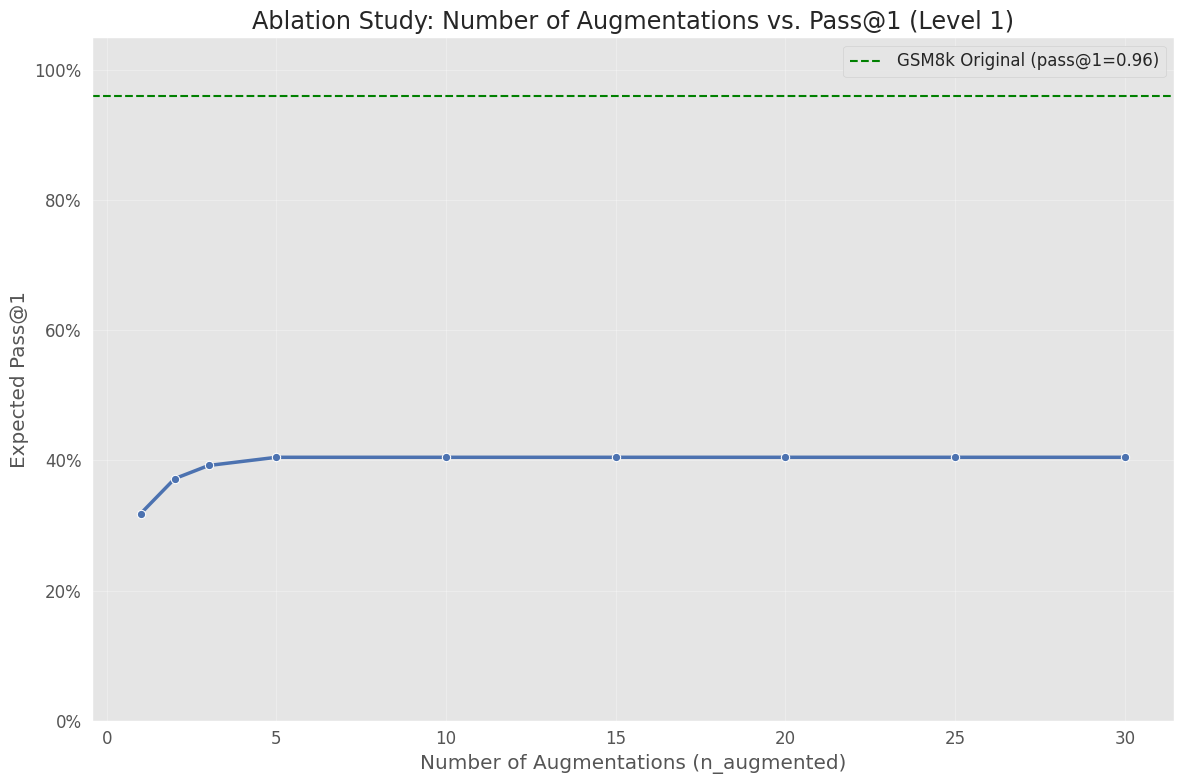

In [30]:
# 3. Ablation study: n_augmented vs. pass@1 (for level 1)
# Use the n30 dataset since it has more samples at one level
level_to_analyze = 1
if 'level' in n30_df.columns:
    level_df = n30_df[n30_df['level'] == level_to_analyze]

    # Calculate pass@1 for different n_augmented values
    n_augmented_values = [1, 2, 3, 5, 10, 15, 20, 25, 30]
    pass_at_1_values = []

    for n in n_augmented_values:
        pass_at_1 = calculate_pass_at_k_at_n_augmented(level_df['correct_predictions'].tolist(), n)
        pass_at_1_values.append(pass_at_1)

    plt.figure(figsize=(12, 8))
    sns.lineplot(x=n_augmented_values, y=pass_at_1_values, marker='o', linewidth=2.5)

    # Add reference line for GSM8k performance
    plt.axhline(y=orig_performance, linestyle='--', color='green',
                label=f'GSM8k Original (pass@1={orig_performance:.2f})')

    plt.title(f'Ablation Study: Number of Augmentations vs. Pass@1 (Level {level_to_analyze})')
    plt.xlabel('Number of Augmentations (n_augmented)')
    plt.ylabel('Expected Pass@1')
    plt.ylim(0, 1.05)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('n_augmented_vs_pass_at_1.png', dpi=300)
    plt.show()

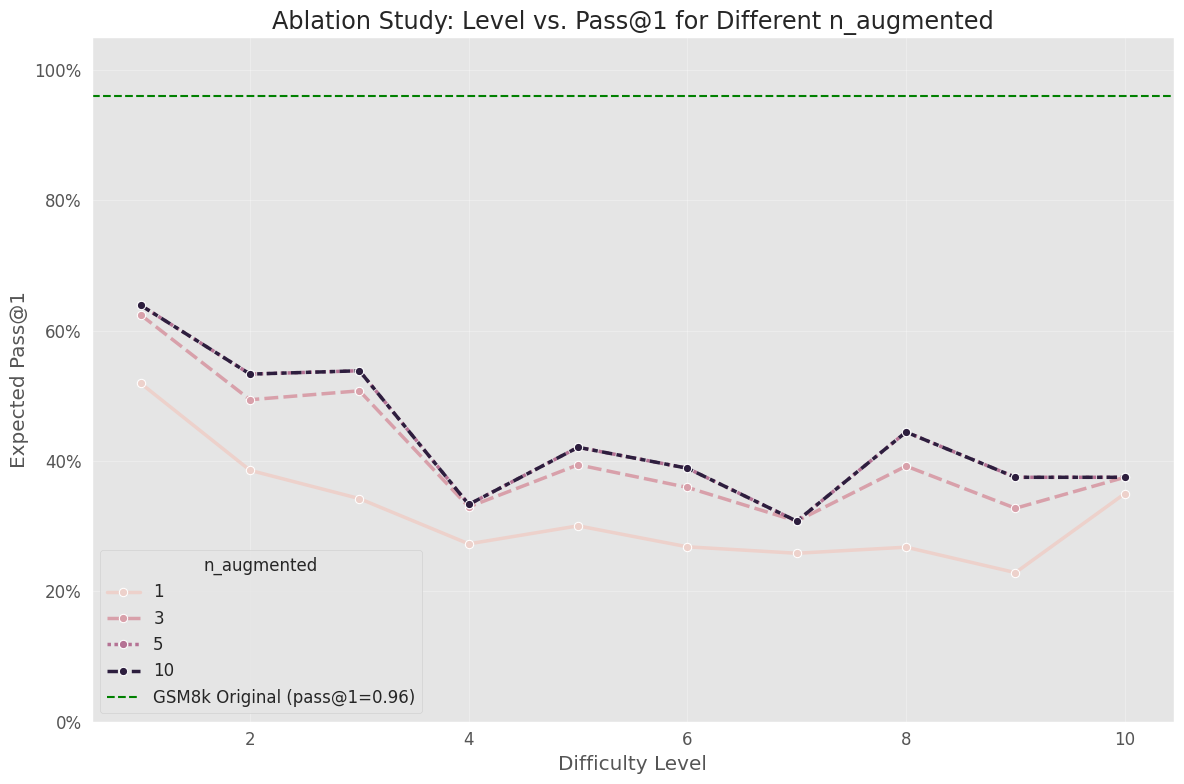

In [31]:
# 4. Ablation study: level vs. pass@1 for different n_augmented
# Use the n10 levels dataset for this analysis
if 'level' in n10_levels_df.columns:
    # Get all unique levels
    levels = sorted(n10_levels_df['level'].unique())
    n_augmented_to_test = [1, 3, 5, 10]

    results = []
    for level in levels:
        level_df = n10_levels_df[n10_levels_df['level'] == level]
        for n in n_augmented_to_test:
            if len(level_df) > 0:
                pass_at_1 = calculate_pass_at_k_at_n_augmented(level_df['correct_predictions'].tolist(), n)
                results.append({
                    'level': level,
                    'n_augmented': n,
                    'pass_at_1': pass_at_1
                })

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(12, 8))
    sns.lineplot(data=results_df, x='level', y='pass_at_1', hue='n_augmented', marker='o',
                 style='n_augmented', linewidth=2.5)

    # Add reference line for GSM8k performance
    plt.axhline(y=orig_performance, linestyle='--', color='green',
                label=f'GSM8k Original (pass@1={orig_performance:.2f})')

    plt.title('Ablation Study: Level vs. Pass@1 for Different n_augmented')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Expected Pass@1')
    plt.ylim(0, 1.05)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.grid(True, alpha=0.3)
    plt.legend(title='n_augmented')
    plt.tight_layout()
    plt.savefig('level_vs_pass_at_1_by_n_augmented.png', dpi=300)
    plt.show()

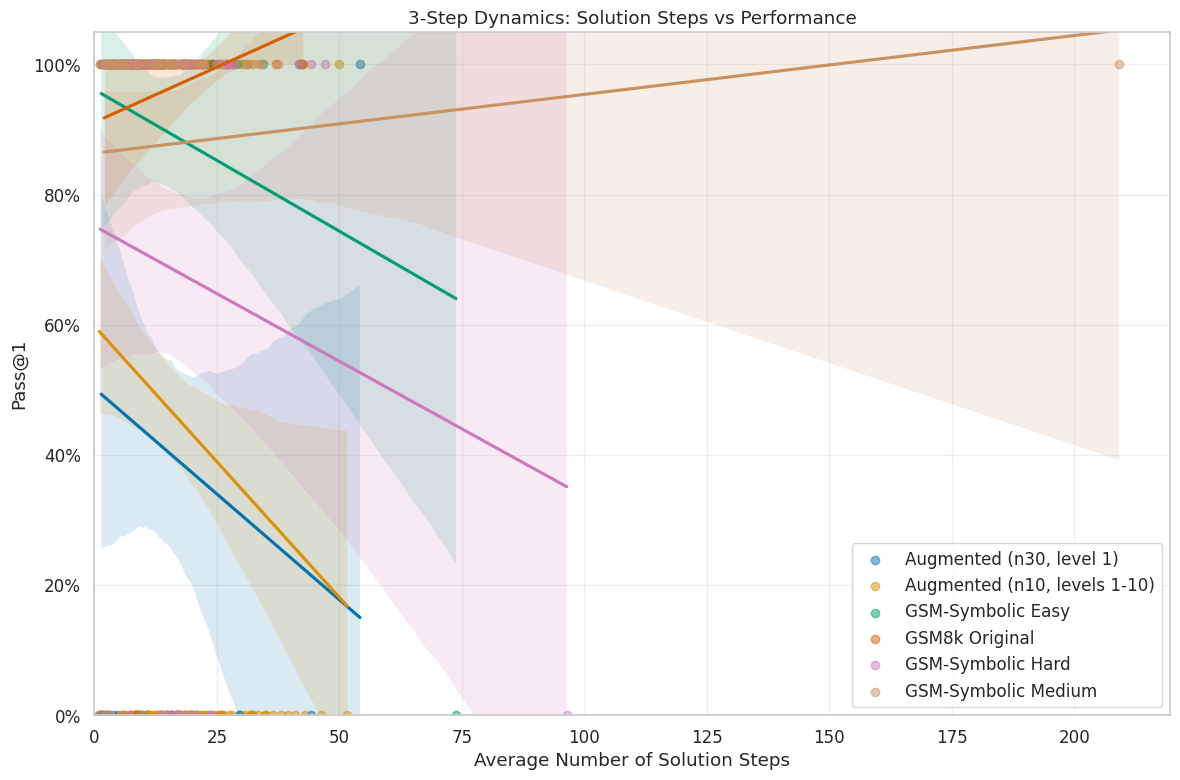

In [44]:
# 5. Step Dynamics Analysis: analyzing solution steps
def extract_step_count(solution_text):
    """Extract the number of steps in a solution."""
    # Count step indicators like "Step 1", "First", etc.
    step_patterns = [
        r'step\s+\d+', r'first', r'second', r'third', r'fourth', r'fifth',
        r'next', r'finally', r'lastly'
    ]

    steps = 0
    for pattern in step_patterns:
        steps += len(re.findall(pattern, solution_text.lower()))

    # If we couldn't find explicit steps, count line breaks as a fallback
    if steps == 0:
        steps = solution_text.count('\n') + 1

    return steps

# Apply to each prediction in each dataset
for name, df in dataframes.items():
    if 'predictions' in df.columns:
        # Calculate average number of steps for each prediction
        df['step_counts'] = df['predictions'].apply(
            lambda preds: [extract_step_count(p) for p in preds if isinstance(p, str)]
        )

        # Average step count per question
        df['avg_steps'] = df['step_counts'].apply(
            lambda steps: np.mean(steps) if len(steps) > 0 else 0
        )

# Plot step dynamics vs performance
plt.figure(figsize=(12, 8))

# Include only datasets with step analysis
for name, df in dataframes.items():
    if 'avg_steps' in df.columns:
        # Plot as scatter with regression line
        sns.regplot(x='avg_steps', y='pass_at_k', data=df,
                   scatter=True, fit_reg=True,
                   label=dataset_names.get(name, name),
                   scatter_kws={'alpha': 0.5})

plt.title('3-Step Dynamics: Solution Steps vs Performance')
plt.xlabel('Average Number of Solution Steps')
plt.ylabel('Pass@1')
plt.ylim(0, 1.05)
plt.xlim(left=0)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('steps_vs_performance.png', dpi=300)
plt.show()

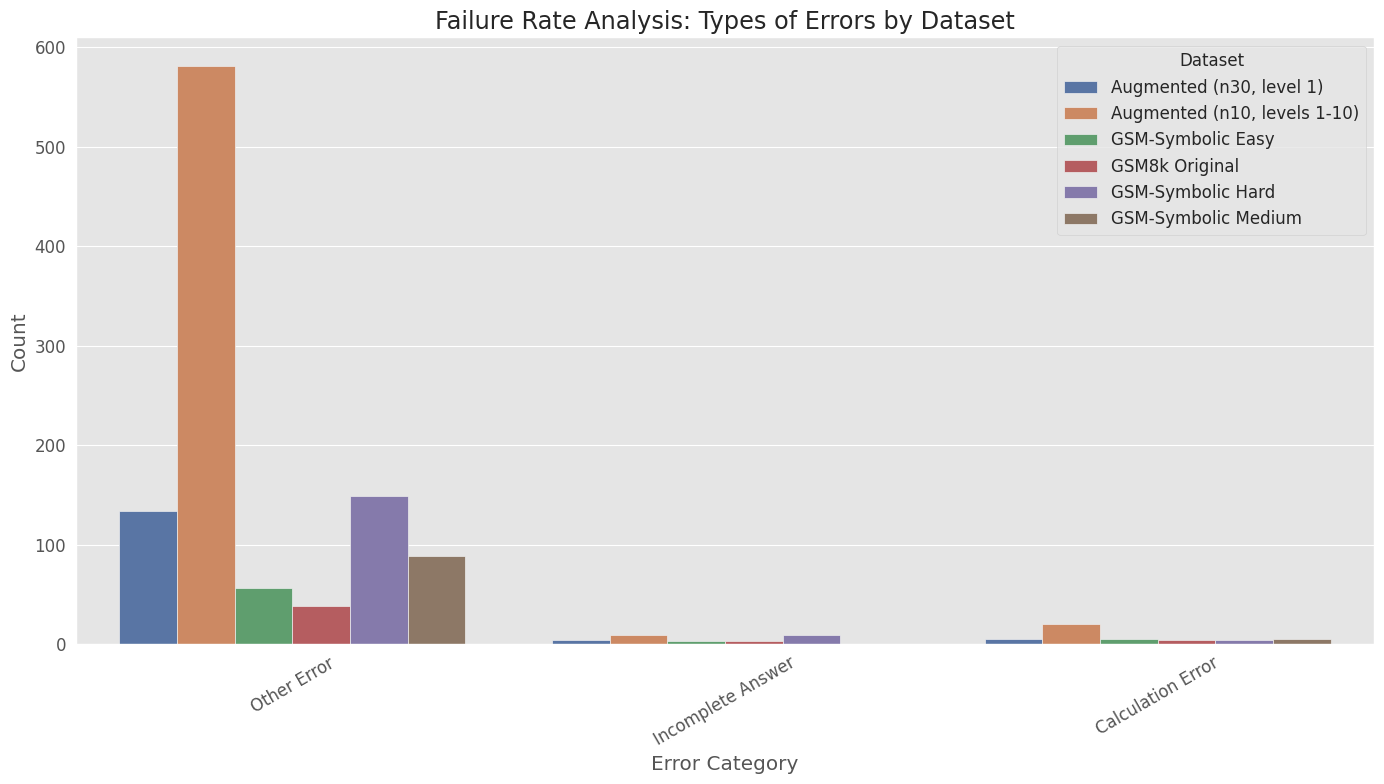

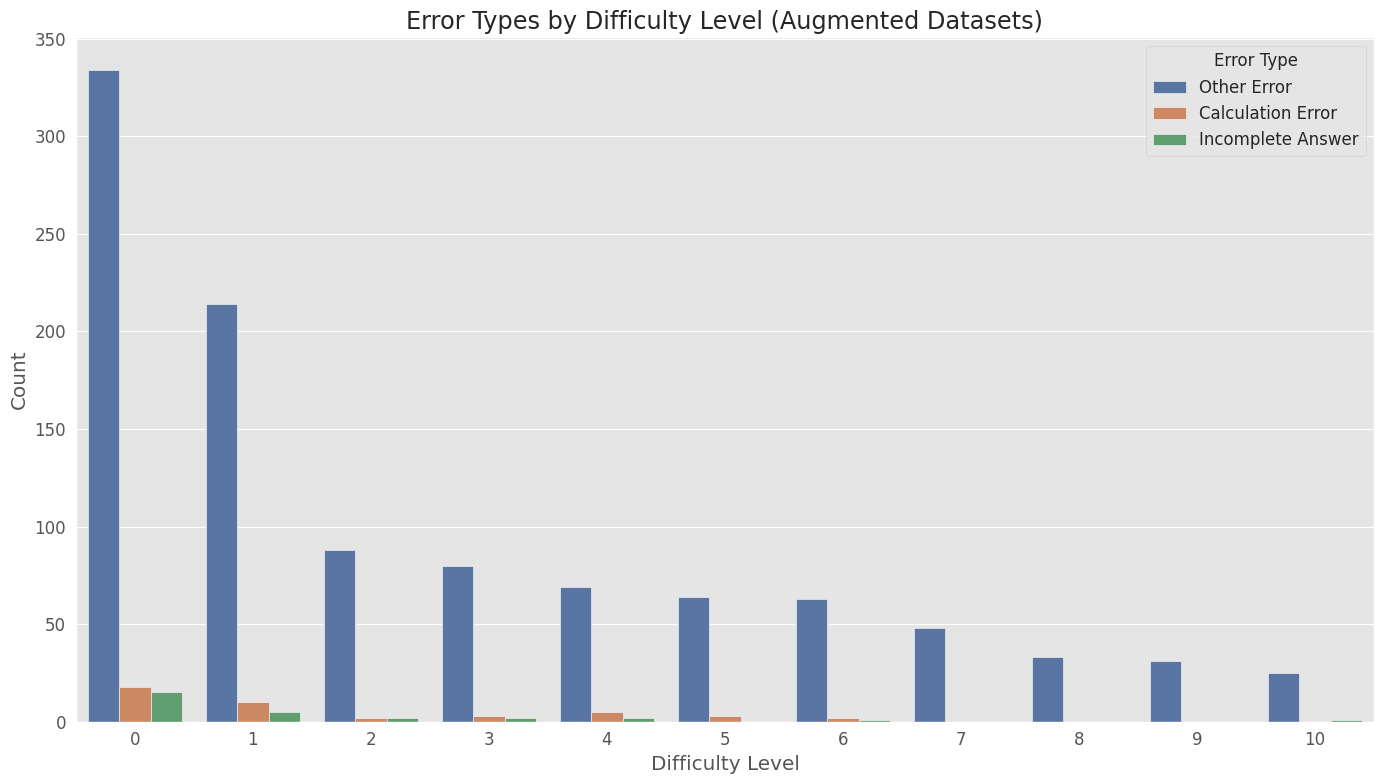

In [34]:
# 6. Failure Rate Analysis: Categorizing error types
def categorize_error(prediction, answer):
    """Categorize the type of error in an incorrect prediction."""
    if not isinstance(prediction, str):
        return "No Answer"

    # Checking for calculation errors
    if "let's think step by step" in prediction.lower() and len(prediction) > 200:
        if re.search(r'the (final |)answer is', prediction.lower()):
            return "Calculation Error"

    # Check for incomplete solutions
    if len(prediction) < 150:
        return "Incomplete Answer"

    # Check for wrong approach
    if "approach" in prediction.lower() and "instead" in prediction.lower():
        return "Wrong Approach"

    # Default case
    return "Other Error"

error_categories = []

for name, df in dataframes.items():
    if 'predictions' in df.columns and 'correct_predictions' in df.columns:
        # Process each sample
        for i, (preds, correct_preds, expected_ans) in enumerate(zip(
                df['predictions'], df['correct_predictions'], df['expected_answer'])):

            # Look at incorrect predictions only
            for j, (pred, is_correct) in enumerate(zip(preds, correct_preds)):
                if not is_correct:
                    error_type = categorize_error(pred, expected_ans)

                    # For augmented data, include level info
                    level = df['level'].iloc[i] if 'level' in df.columns else 'N/A'

                    error_categories.append({
                        'dataset': dataset_names.get(name, name),
                        'error_type': error_type,
                        'level': level
                    })

# Convert to DataFrame
error_df = pd.DataFrame(error_categories)

# Plot error categories
plt.figure(figsize=(14, 8))
sns.countplot(data=error_df, x='error_type', hue='dataset')
plt.title('Failure Rate Analysis: Types of Errors by Dataset')
plt.xlabel('Error Category')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.legend(title='Dataset', loc='upper right')
plt.tight_layout()
plt.savefig('error_categories.png', dpi=300)
plt.show()

# Plot error categories by level (for augmented datasets)
plt.figure(figsize=(14, 8))
augmented_errors = error_df[error_df['level'] != 'N/A']
if not augmented_errors.empty:
    sns.countplot(data=augmented_errors, x='level', hue='error_type')
    plt.title('Error Types by Difficulty Level (Augmented Datasets)')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Count')
    plt.legend(title='Error Type')
    plt.tight_layout()
    plt.savefig('errors_by_level.png', dpi=300)
    plt.show()

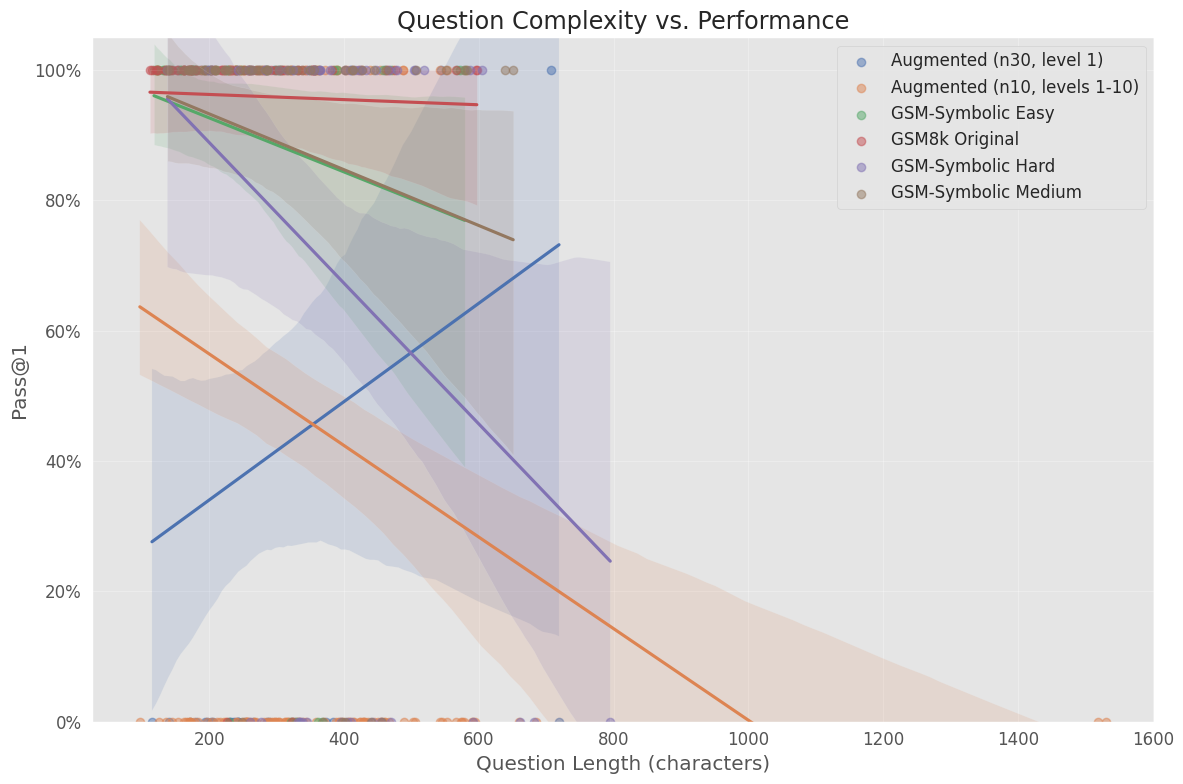

In [35]:
# 7. Question complexity vs performance
plt.figure(figsize=(12, 8))

for name, df in dataframes.items():
    if 'question' in df.columns:
        # Calculate question complexity (length as a proxy)
        df['question_length'] = df['question'].apply(len)

        # Create scatter plot with trend line
        sns.regplot(x='question_length', y='pass_at_k', data=df,
                   scatter=True, fit_reg=True,
                   label=dataset_names.get(name, name),
                   scatter_kws={'alpha': 0.5})

plt.title('Question Complexity vs. Performance')
plt.xlabel('Question Length (characters)')
plt.ylabel('Pass@1')
plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('complexity_vs_performance.png', dpi=300)
plt.show()

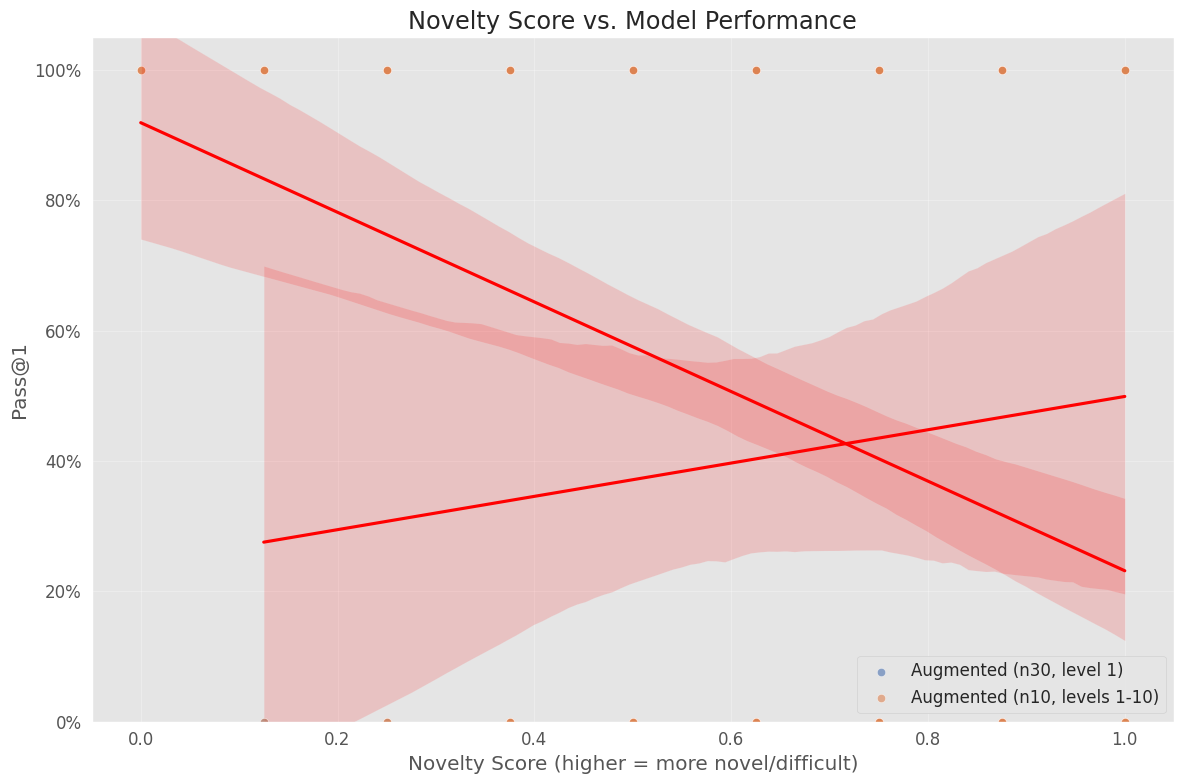

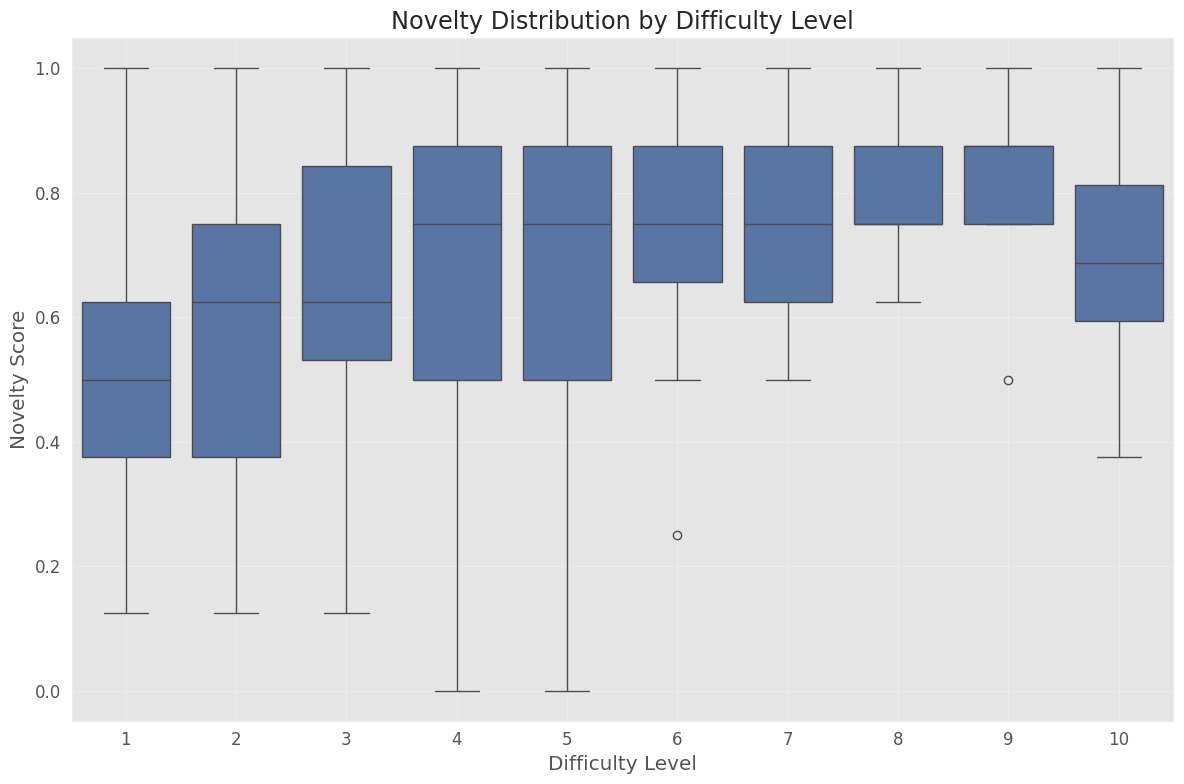

In [36]:
# 8. Novelty analysis for augmented datasets
plt.figure(figsize=(12, 8))

for name, df in dataframes.items():
    if 'novelty' in df.columns and pd.notna(df['novelty']).any():
        # Create scatter plot of novelty vs performance
        sns.scatterplot(x='novelty', y='pass_at_k', data=df,
                        alpha=0.6, label=dataset_names.get(name, name))

        # Add trend line
        sns.regplot(x='novelty', y='pass_at_k', data=df,
                   scatter=False, line_kws={'color': 'red'})

plt.title('Novelty Score vs. Model Performance')
plt.xlabel('Novelty Score (higher = more novel/difficult)')
plt.ylabel('Pass@1')
plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('novelty_vs_performance.png', dpi=300)
plt.show()

# Also analyze novelty by level for the n10 dataset
if 'level' in n10_levels_df.columns and 'novelty' in n10_levels_df.columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='level', y='novelty', data=n10_levels_df)
    plt.title('Novelty Distribution by Difficulty Level')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Novelty Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('novelty_by_level.png', dpi=300)
    plt.show()

In [37]:
# 9. Summary statistics and performance metrics
summary_data = []

for name, df in dataframes.items():
    avg_pass = df['pass_at_k'].mean()
    samples = len(df)

    if 'level' in df.columns:
        levels = df['level'].nunique()
    else:
        levels = 'N/A'

    if 'novelty' in df.columns and pd.notna(df['novelty']).any():
        avg_novelty = df['novelty'].mean()
    else:
        avg_novelty = 'N/A'

    summary_data.append({
        'Dataset': dataset_names.get(name, name),
        'Samples': samples,
        'Difficulty Levels': levels,
        'Pass@1': f"{avg_pass:.2f}",
        'Avg Novelty': avg_novelty if avg_novelty == 'N/A' else f"{avg_novelty:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df

,Dataset,Samples,Difficulty Levels,Pass@1,Avg Novelty
0,"Augmented (n30, level 1)",42,1,0.40,0.631
1,"Augmented (n10, levels 1-10)",188,10,0.47,0.648
2,GSM-Symbolic Easy,50,1,0.90,N/A
3,GSM8k Original,50,1,0.96,N/A
4,GSM-Symbolic Hard,50,1,0.68,N/A
5,GSM-Symbolic Medium,50,1,0.88,N/A


Loaded augmented_best_eval_result_len_42 with 42 rows
Loaded augmented_best_eval_result_len_188 with 188 rows
Loaded selected_easy_eval_result_len_50 with 50 rows
Loaded selected_gsm8k_eval_result_len_50 with 50 rows
Loaded selected_hard_eval_result_len_50 with 50 rows
Loaded selected_medium_eval_result_len_50 with 50 rows


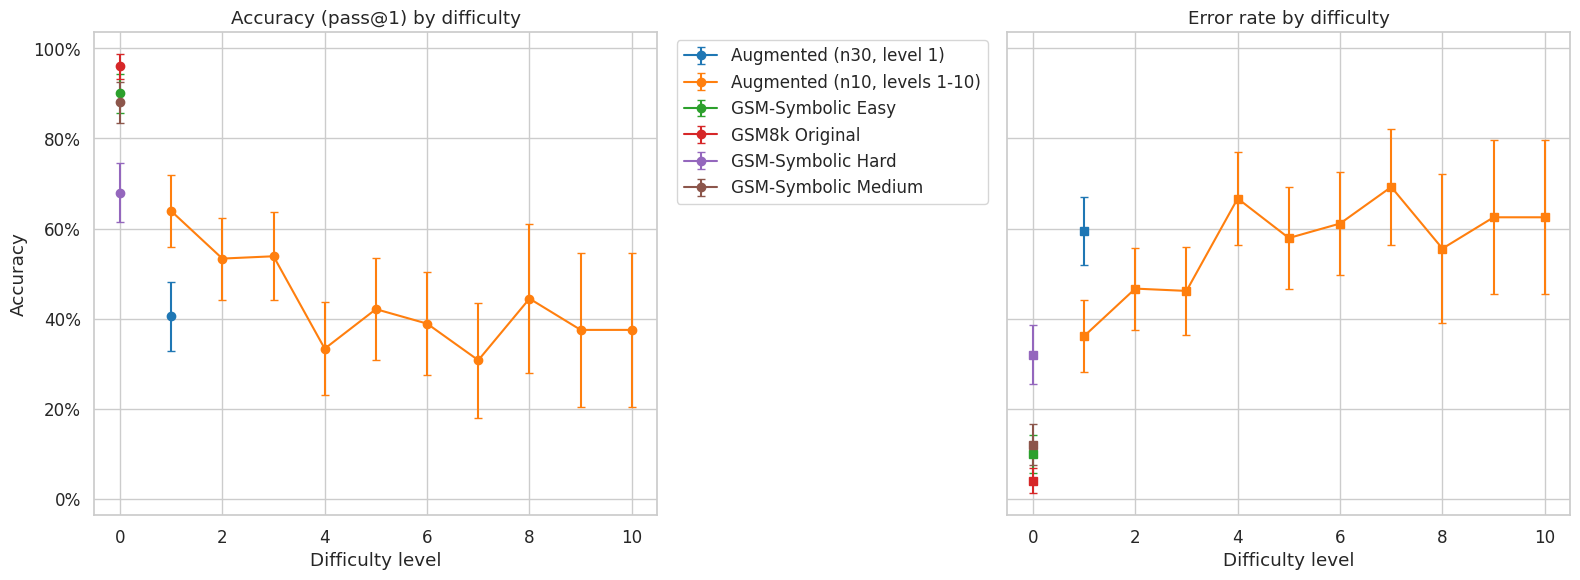

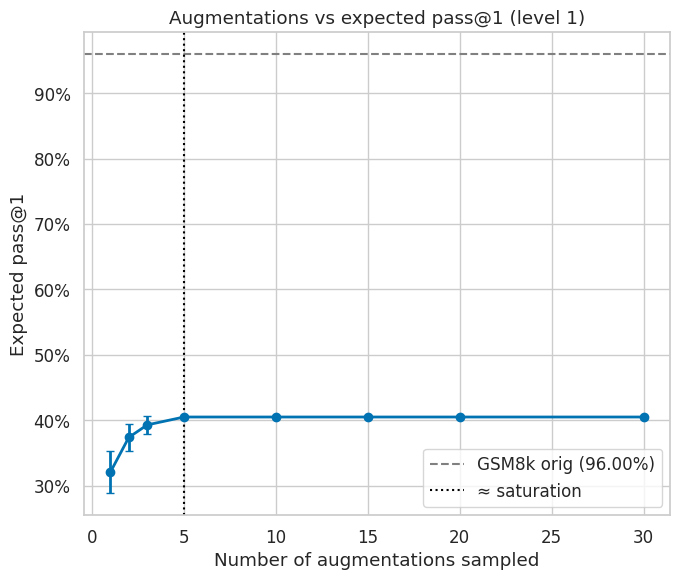

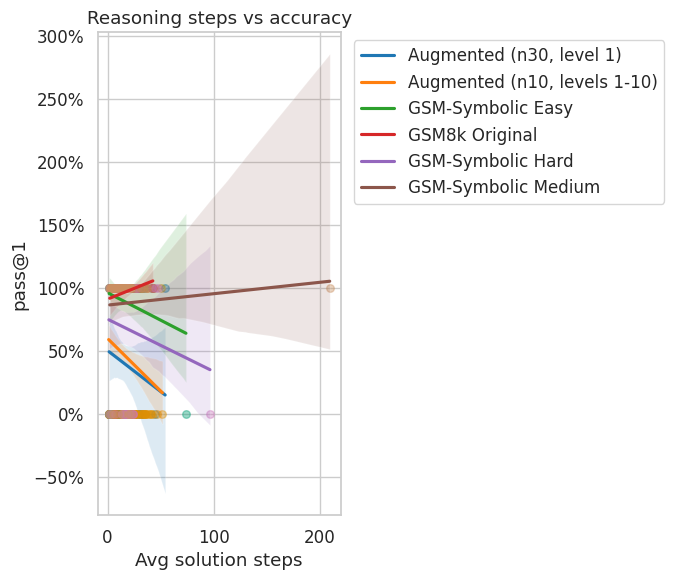

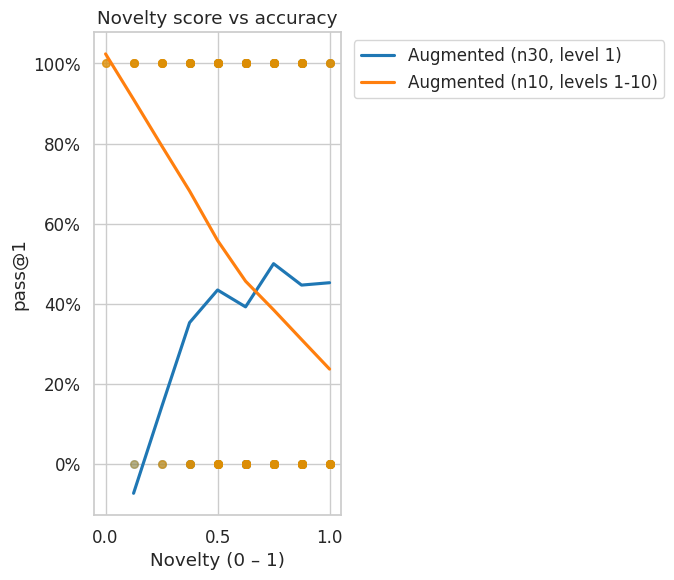

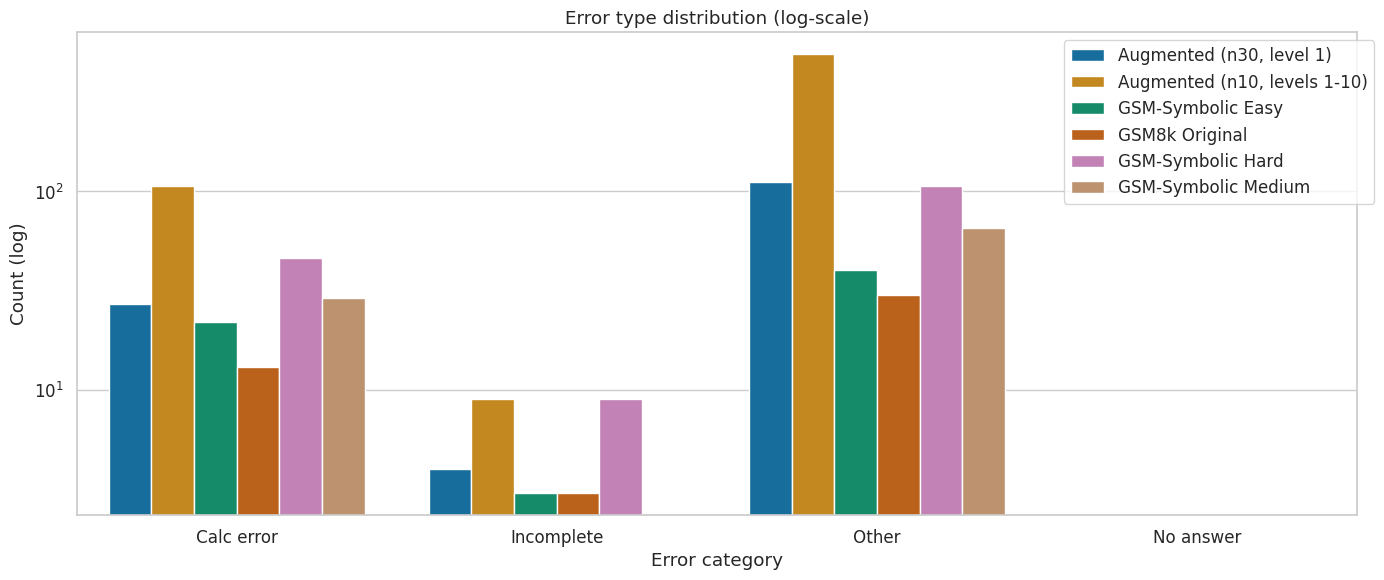

In [4]:
# ============================
# clean_plots.py  (Python ≥3.9)
# ============================
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, re, random
from matplotlib.ticker import PercentFormatter


file_paths = [
    '/gpfs/home6/mmokkenstorm/augmented_datasets/n30/augmented_best_eval_result_len_42.csv',
    '/gpfs/home6/mmokkenstorm/augmented_datasets/n10_gsm8k_eval/augmented_best_eval_result_len_188.csv',
    '/gpfs/home6/mmokkenstorm/augmented_datasets/n30/selected_easy_eval_result_len_50.csv',
    '/gpfs/home6/mmokkenstorm/augmented_datasets/n30/selected_gsm8k_eval_result_len_50.csv',
    '/gpfs/home6/mmokkenstorm/augmented_datasets/n30/selected_hard_eval_result_len_50.csv',
    '/gpfs/home6/mmokkenstorm/augmented_datasets/n30/selected_medium_eval_result_len_50.csv'
]

# Create better names for visualization
dataset_names = {
    'augmented_best_eval_result_len_42': 'Augmented (n30, level 1)',
    'augmented_best_eval_result_len_188': 'Augmented (n10, levels 1-10)',
    'selected_easy_eval_result_len_50': 'GSM-Symbolic Easy',
    'selected_gsm8k_eval_result_len_50': 'GSM8k Original',
    'selected_hard_eval_result_len_50': 'GSM-Symbolic Hard',
    'selected_medium_eval_result_len_50': 'GSM-Symbolic Medium'
}

# Load all datasets
dataframes = {}
for file_path in file_paths:
    df_name = file_path.split('/')[-1].replace('.csv', '')
    df = pd.read_csv(file_path)

    # Convert string representations of lists to actual lists where needed
    for col in ['predictions', 'correct_predictions', 'extracted_answers']:
        if col in df.columns and isinstance(df[col].iloc[0], str):
            df[col] = df[col].apply(eval)

    dataframes[df_name] = df
    print(f"Loaded {df_name} with {len(df)} rows")
# ---------- CONFIG ----------
sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.1)
FIGSIZE_WIDE = (14, 6)
FIGSIZE_SQUARE = (7, 6)
PERCENT_FMT = PercentFormatter(1.0, decimals=0)
# unified colour map for datasets
DS_COLOURS = {
    'Augmented (n30, level 1)': '#1f77b4',
    'Augmented (n10, levels 1-10)': '#ff7f0e',
    'GSM-Symbolic Easy': '#2ca02c',
    'GSM8k Original': '#d62728',
    'GSM-Symbolic Hard': '#9467bd',
    'GSM-Symbolic Medium': '#8c564b',
}

# ---------- HELPERS ----------
def calc_pass_at_1(predictions, n_aug, reps=1_000):
    """Monte-Carlo expected pass@1 with n_aug samples."""
    rng = np.random.default_rng(42)
    samples = []
    for _ in range(reps):
        ok = [rng.choice(p, size=min(n_aug, len(p)), replace=False).any() for p in predictions]
        samples.append(np.mean(ok))
    return np.mean(samples), np.std(samples)

def extract_steps(text: str) -> int:
    patterns = r'(step\s+\d+|first|second|third|fourth|fifth|next|finally|lastly)'
    found = len(re.findall(patterns, text.lower()))
    return found or text.count('\n') + 1

# ---------- LOAD ------------
file_root = '/gpfs/home6/mmokkenstorm/augmented_datasets'
paths = {
    'Augmented (n30, level 1)'     : f'{file_root}/n30/augmented_best_eval_result_len_42.csv',
    'Augmented (n10, levels 1-10)' : f'{file_root}/n10_gsm8k_eval/augmented_best_eval_result_len_188.csv',
    'GSM-Symbolic Easy'            : f'{file_root}/n30/selected_easy_eval_result_len_50.csv',
    'GSM8k Original'               : f'{file_root}/n30/selected_gsm8k_eval_result_len_50.csv',
    'GSM-Symbolic Hard'            : f'{file_root}/n30/selected_hard_eval_result_len_50.csv',
    'GSM-Symbolic Medium'          : f'{file_root}/n30/selected_medium_eval_result_len_50.csv',
}

dfs = {}
for name, path in paths.items():
    df = pd.read_csv(path)
    for col in ['predictions', 'correct_predictions', 'extracted_answers']:
        if col in df and isinstance(df[col].iloc[0], str):
            df[col] = df[col].apply(eval)
    dfs[name] = df

# ---------- PLOT 1 · level vs pass@1 & error ----------
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for name, df in dfs.items():
    if 'level' not in df: continue
    by_lvl = df.groupby('level')['pass_at_k'].agg(['mean', 'count'])
    ax[0].errorbar(by_lvl.index, by_lvl['mean'],
                   yerr=np.sqrt(by_lvl['mean']*(1-by_lvl['mean'])/by_lvl['count']),
                   marker='o', capsize=3, label=name,
                   color=DS_COLOURS[name])
    ax[1].errorbar(by_lvl.index, 1-by_lvl['mean'],
                   yerr=np.sqrt(by_lvl['mean']*(1-by_lvl['mean'])/by_lvl['count']),
                   marker='s', capsize=3, label=name,
                   color=DS_COLOURS[name])

ax[0].set(title='Accuracy (pass@1) by difficulty',
          xlabel='Difficulty level', ylabel='Accuracy')
ax[1].set(title='Error rate by difficulty',
          xlabel='Difficulty level')
for a in ax: a.yaxis.set_major_formatter(PERCENT_FMT)
ax[0].legend(title=None, bbox_to_anchor=(1.02, 1), loc='upper left')
fig.tight_layout()
fig.savefig('clean_level_accuracy_error.png', dpi=300)

# ---------- PLOT 2 · ablation n_aug ----------
base_df = dfs['Augmented (n30, level 1)']
preds = base_df['correct_predictions']
n_values = [1, 2, 3, 5, 10, 15, 20, 30]
means, stds = zip(*[calc_pass_at_1(preds, n) for n in n_values])

plt.figure(figsize=FIGSIZE_SQUARE)
plt.errorbar(n_values, means, yerr=stds, marker='o', capsize=3, lw=2)
gsm_ref = dfs['GSM8k Original']['pass_at_k'].mean()
plt.axhline(gsm_ref, ls='--', color='grey', label=f'GSM8k orig ({gsm_ref:.2%})')
plt.axvline(5, ls=':', color='black', label='≈ saturation')
plt.title('Augmentations vs expected pass@1 (level 1)')
plt.xlabel('Number of augmentations sampled')
plt.ylabel('Expected pass@1'); plt.gca().yaxis.set_major_formatter(PERCENT_FMT)
plt.legend(); plt.tight_layout(); plt.savefig('clean_n_aug.png', dpi=300)

# ---------- PLOT 3 · steps vs accuracy ----------
plt.figure(figsize=FIGSIZE_SQUARE)
for name, df in dfs.items():
    if 'predictions' not in df: continue
    df = df.copy()
    df['avg_steps'] = df['predictions'].apply(
        lambda plist: np.mean([extract_steps(p) for p in plist if isinstance(p, str)]) )
    sns.regplot(x='avg_steps', y='pass_at_k', data=df,
                scatter_kws={'alpha':0.4, 's':30},
                line_kws={'label':name, 'color':DS_COLOURS[name]},
                truncate=True, ci=95)
plt.title('Reasoning steps vs accuracy')
plt.xlabel('Avg solution steps'); plt.ylabel('pass@1')
plt.gca().yaxis.set_major_formatter(PERCENT_FMT)
plt.legend(title=None, bbox_to_anchor=(1.02, 1)); plt.tight_layout()
plt.savefig('clean_steps.png', dpi=300)

# ---------- PLOT 4 · novelty vs accuracy ----------
plt.figure(figsize=FIGSIZE_SQUARE)
for name, df in dfs.items():
    if 'novelty' not in df: continue
    sns.regplot(x='novelty', y='pass_at_k', data=df,
                scatter_kws={'alpha':0.4, 's':30},
                line_kws={'label':name, 'color':DS_COLOURS[name]},
                lowess=True, ci=95)
plt.title('Novelty score vs accuracy')
plt.xlabel('Novelty (0 – 1)'); plt.ylabel('pass@1')
plt.gca().yaxis.set_major_formatter(PERCENT_FMT)
plt.legend(title=None, bbox_to_anchor=(1.02, 1)); plt.tight_layout()
plt.savefig('clean_novelty.png', dpi=300)

# ---------- PLOT 5 · error categories ----------
err_rows = []
for name, df in dfs.items():
    if 'predictions' not in df: continue
    for preds, corrects in zip(df['predictions'], df['correct_predictions']):
        for p, ok in zip(preds, corrects):
            if ok: continue
            if not isinstance(p, str): et = 'No answer'
            elif len(p) < 150:        et = 'Incomplete'
            elif re.search(r'\banswer is\b', p, flags=re.I): et = 'Calc error'
            else:                     et = 'Other'
            err_rows.append((name, et))
err_df = pd.DataFrame(err_rows, columns=['dataset','etype'])
plt.figure(figsize=FIGSIZE_WIDE)
sns.countplot(data=err_df, x='etype', hue='dataset', order=['Calc error','Incomplete','Other','No answer'],
              hue_order=DS_COLOURS.keys())
plt.yscale('log')                       # makes the minor categories visible
plt.title('Error type distribution (log-scale)')
plt.xlabel('Error category'); plt.ylabel('Count (log)')
plt.legend(title=None, bbox_to_anchor=(1.02, 1))
plt.tight_layout(); plt.savefig('clean_errors.png', dpi=300)


In [49]:
    # !pip install statsmodels
# import statsmodels

NameError: name 'n30_df' is not defined

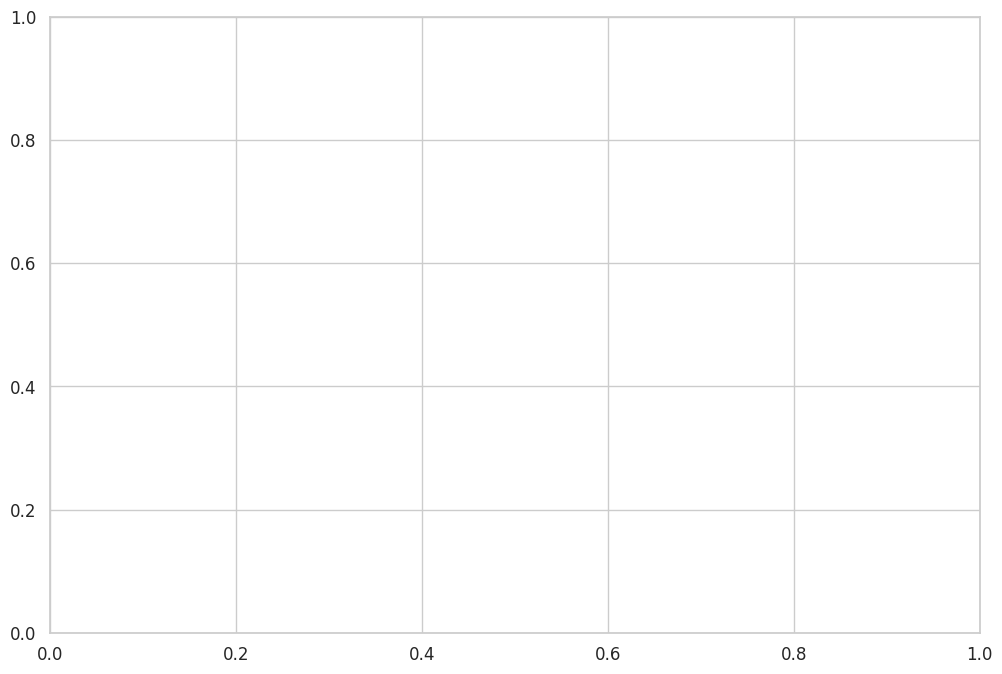